In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import constants as cnst, u_darrays as uda
import salem
import xarray as xr
# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
import ipdb
sns.set_style('ticks')

In [3]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [72]:
chirps = '/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.daily.peru.nc'

fpath = cnst.network_data + 'figs/HUARAZ/'

fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
isbuffer = [-79, -74, -12, -7]

sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

ca = xr.open_dataarray(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3])).salem.roi(shape=sdf)
# Rio Santa basin only


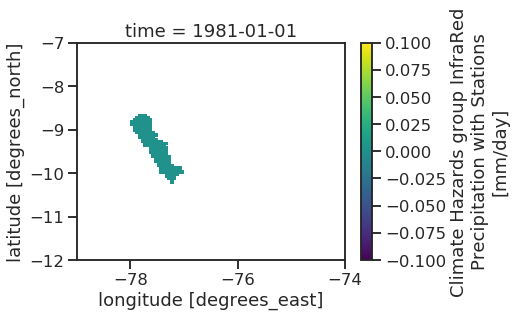

In [73]:
ca[0,:,:].plot()

In [74]:
ca = ca.mean(['latitude', 'longitude'])

In [75]:
np.unique(ca['time.year'])

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019])

In [76]:
class RainySeason(pd.Series):
    """ Class doc"""

    def __init__(self, data):
        """ Class initialiser """
        assert isinstance(data, pd.Series), "Exp series got {0.__class__}".format(data)
        if data.index.dtype == int:
            idx = data.index
        else:
            idx = np.arange(data.index.size) + 1


        #print(idx.min())
       # print(idx.max())
        if idx.max() < 365:
            print('Problem, not enough days')
            ipdb.set_trace()

        assert idx.min() == 1 and idx.max() in (365, 366) #testing for right format, else AssertionError
        ts = data.fillna(0)
        mrr = ts.mean()
        diff = ts - mrr
        cumdif = diff.cumsum()

        pd.Series.__init__(self, cumdif.values, index=idx)

In [97]:
def year_calc(data, y, img=False):


    print('Doing '+str(y))
    
    ryear_start = str(y)+'-07-01'
    ryear_end = str(y+1)+'-06-30'

    data = data.sel(time=slice(ryear_start, ryear_end))

    tstart=[]
    tend = []
    md = data.to_pandas()
    md = md.reindex(pd.date_range(ryear_start, ryear_end, freq='D'), fill_value=0)

    diff = RainySeason(md)

    dstart= np.argmin(diff)
    dend=np.argmax(diff)
    
    if img:
        f = plt.figure()
        ax = f.add_subplot(111)
        plt.plot(diff.index, diff)
        plt.axvline(dstart, color='k')
        plt.axvline(dend, color='k')
        plt.text(dstart-1, -50, str(dstart))
        plt.text(dend-1, -50, str(dend))
        plt.minorticks_on()
        plt.title('Cumulative rainfall anomaly')
        
        f.savefig(psave + 'cumulative_rs_example_2000.jpg')

        date = pd.to_datetime(ryear_start) + pd.Timedelta(str(dstart - 1)+' days')
        dstr = date.strftime("%d/%m")
        print('Huaraz onset since July', dstart, 'Date', dstr)

        date = pd.to_datetime(ryear_start) + pd.Timedelta(str(dend - 1)+' days')
        dstr = date.strftime("%d/%m")
        print('Huaraz retreat since July', dend, 'Date', dstr)

    return dstart, dend

Doing 2000
Huaraz onset since July 144 Date 21/11
Huaraz retreat since July 276 Date 02/04


(144, 276)

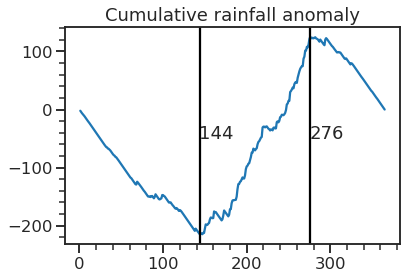

In [98]:
year_calc(ca, 2000, img=True)

In [99]:
## save years
psave = '/home/ck/DIR/cornkle/figs/HUARAZ/'

years = np.arange(1981, 2019)
start=[]
end = []

for y in years:
    sstart, send = year_calc(ca, y)
    start.append(sstart)
    end.append(send)

np.save(psave+'saves/start_season.npy',np.array(start))
np.save(psave + 'saves/end_season.npy', np.array(end))

Doing 1981
Doing 1982
Doing 1983
Doing 1984
Doing 1985
Doing 1986
Doing 1987
Doing 1988
Doing 1989
Doing 1990
Doing 1991
Doing 1992
Doing 1993
Doing 1994
Doing 1995
Doing 1996
Doing 1997
Doing 1998
Doing 1999
Doing 2000
Doing 2001
Doing 2002
Doing 2003
Doing 2004
Doing 2005
Doing 2006
Doing 2007
Doing 2008
Doing 2009
Doing 2010
Doing 2011
Doing 2012
Doing 2013
Doing 2014
Doing 2015
Doing 2016
Doing 2017
Doing 2018


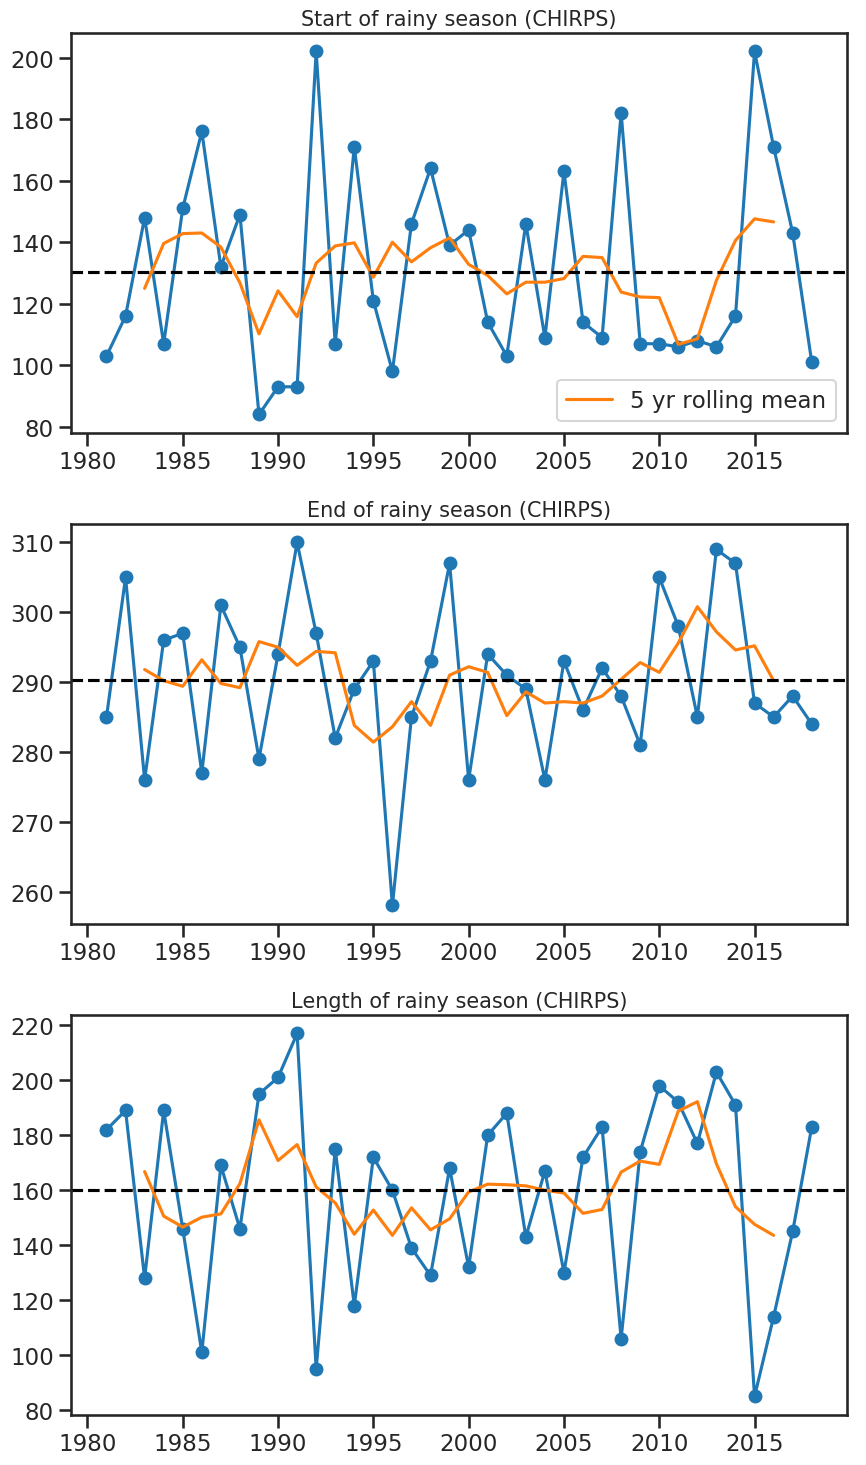

In [100]:
start= np.load(psave+'saves/start_season.npy')
end = np.load(psave + 'saves/end_season.npy')

pstart = pd.Series(start, index=years)
pend = pd.Series(end, index=years)

diff = pd.Series(end - start, index=years)

f = plt.figure(figsize=(9,15), dpi=100)
f.add_subplot(3, 1, 1)

plt.plot(years, pstart, marker='o')
plt.plot(years, pstart.rolling(center=True,window=5).mean(), label='5 yr rolling mean')
plt.axhline(pstart.mean(), color='k', linestyle='dashed')
plt.title('Start of rainy season (CHIRPS)', fontsize=15)
plt.legend()

f.add_subplot(3, 1, 2)
plt.plot(years, pend, marker='o')
plt.plot(years, pend.rolling(center=True,window=5).mean())
plt.axhline(pend.mean(), color='k', linestyle='dashed')
plt.title('End of rainy season (CHIRPS)', fontsize=15)

f.add_subplot(3, 1, 3)
plt.plot(years, diff, marker='o')
plt.plot(years, diff.rolling(center=True,window=5).mean())
plt.axhline(diff.mean(), color='k', linestyle='dashed')
plt.title('Length of rainy season (CHIRPS)', fontsize=15)
plt.tight_layout()
f.savefig(psave + 'cumulative_rainy_season_CHIRPS.jpg')